Epoch 1/1000, Loss: 0.2116
Epoch 2/1000, Loss: 0.0844
Epoch 3/1000, Loss: 0.0742
Epoch 4/1000, Loss: 0.0728
Epoch 5/1000, Loss: 0.0704
Epoch 6/1000, Loss: 0.0702
Epoch 7/1000, Loss: 0.0694
Epoch 8/1000, Loss: 0.0686
Epoch 9/1000, Loss: 0.0691
Epoch 10/1000, Loss: 0.0683
Epoch 11/1000, Loss: 0.0669
Epoch 12/1000, Loss: 0.0662
Epoch 13/1000, Loss: 0.0622
Epoch 14/1000, Loss: 0.0567
Epoch 15/1000, Loss: 0.0552
Epoch 16/1000, Loss: 0.0515
Epoch 17/1000, Loss: 0.0506
Epoch 18/1000, Loss: 0.0501
Epoch 19/1000, Loss: 0.0472
Epoch 20/1000, Loss: 0.0448
Epoch 21/1000, Loss: 0.0450
Epoch 22/1000, Loss: 0.0434
Epoch 23/1000, Loss: 0.0435
Epoch 24/1000, Loss: 0.0429
Epoch 25/1000, Loss: 0.0416
Epoch 26/1000, Loss: 0.0397
Epoch 27/1000, Loss: 0.0381
Epoch 28/1000, Loss: 0.0367
Epoch 29/1000, Loss: 0.0355
Epoch 30/1000, Loss: 0.0346
Epoch 31/1000, Loss: 0.0342
Epoch 32/1000, Loss: 0.0339
Epoch 33/1000, Loss: 0.0328
Epoch 34/1000, Loss: 0.0320
Epoch 35/1000, Loss: 0.0316
Epoch 36/1000, Loss: 0.0307
E

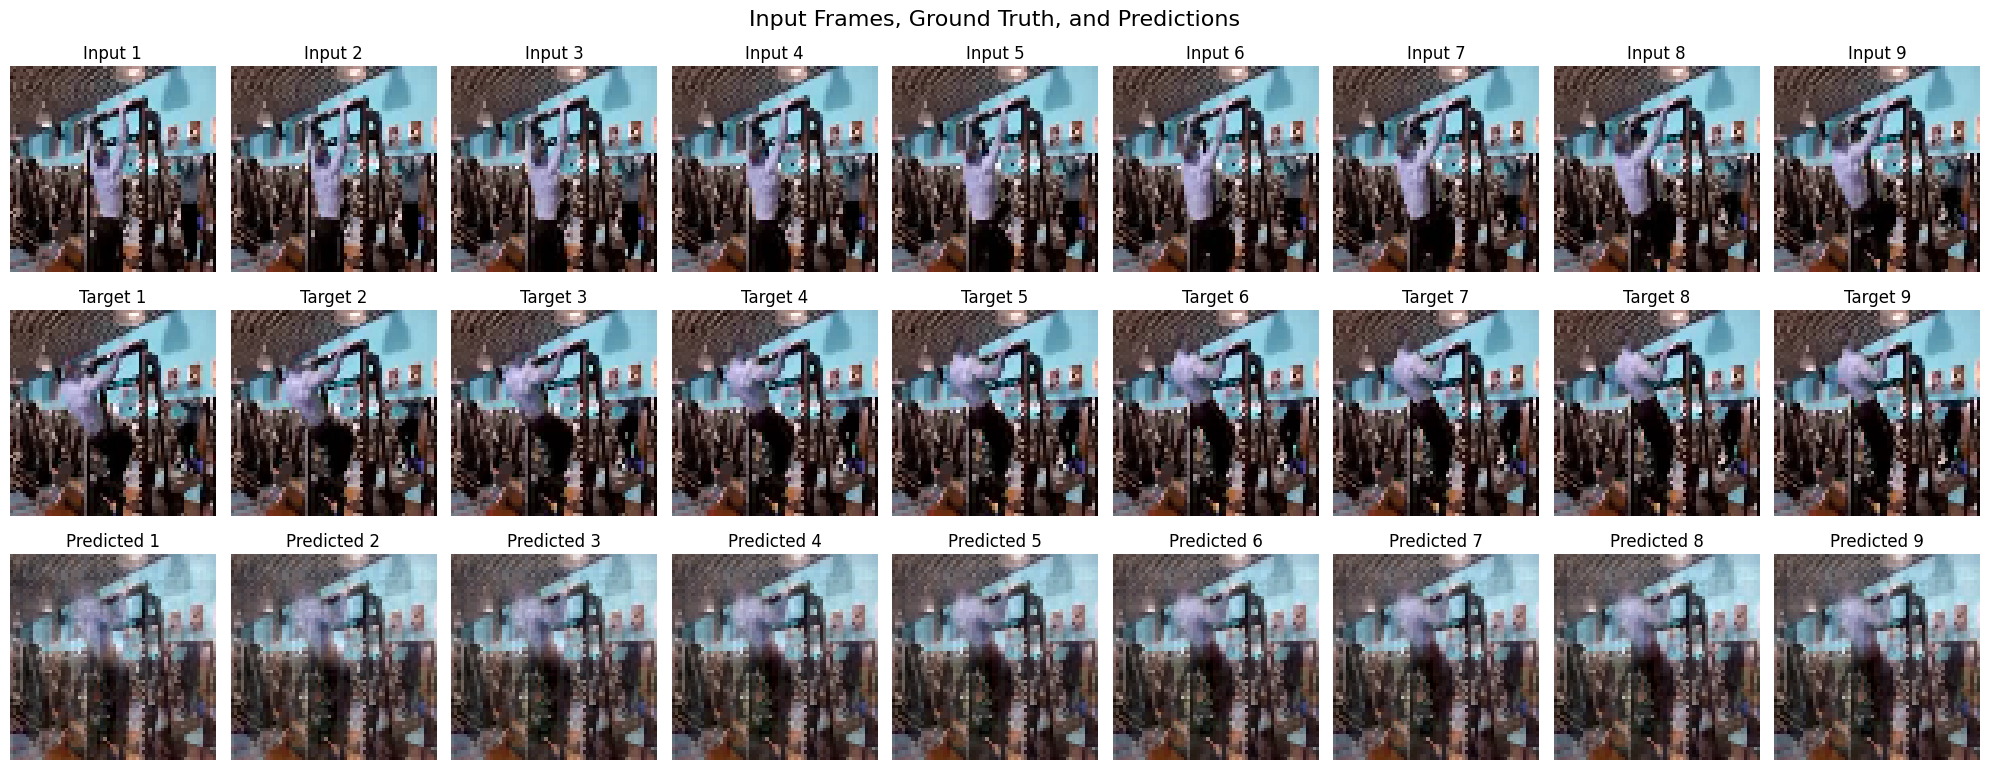

Video saved to video_transformer.mp4


In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#for now run on one class 
train_path = '/kaggle/input/ucf101-action-recognition/train/PullUps'
test_path = '/kaggle/input/ucf101-action-recognition/test/PullUps'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 10
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_videos(video_path, frame_size, sequence_length, prediction_length):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

train_video_data = preprocess_videos(train_path, frame_size, sequence_length, prediction_length)
test_video_data = preprocess_videos(test_path, frame_size, sequence_length, prediction_length)

class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

train_dataset = VideoDataset(train_video_data, sequence_length, prediction_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = VideoDataset(test_video_data, sequence_length, prediction_length)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  
        target = target.view(b, target.size(1), -1)

        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

#instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

#training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        #model prediction
        predictions = model(inputs, targets[:, :-1])  #use inputs and part of targets for prediction
        
        #align target shape with predictions
        aligned_targets = targets[:, 1:]  #shifted by one step to match prediction sequence
        
        #calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}")

def visualize_test_results(inputs, targets, predictions):
    #convert tensors to numpy for visualization
    inputs = inputs.cpu().numpy()[0]
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    num_frames = min(len(inputs), len(targets), len(predictions))  
    fig, axes = plt.subplots(3, num_frames, figsize=(20, 8))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    #input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    #ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    #predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

def generate_video_from_frames(inputs, targets, predictions, output_path='video_transformer.mp4'):
    #convert tensors to numpy
    inputs = inputs.cpu().numpy()[0]
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    num_frames = min(len(inputs), len(targets), len(predictions))

    #prepare figure for video
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Video Frame Prediction Comparison", fontsize=16)
    
    #prepare placeholders for images
    im1 = axes[0].imshow(inputs[0])
    im2 = axes[1].imshow(targets[0])
    im3 = axes[2].imshow(predictions[0])
    
    axes[0].set_title("Input Frames")
    axes[1].set_title("Ground Truth")
    axes[2].set_title("Predicted Frames")
    
    for ax in axes:
        ax.axis('off')

    #animation update function
    def update(frame):
        im1.set_array(inputs[frame])
        im2.set_array(targets[frame])
        im3.set_array(predictions[frame])
        return [im1, im2, im3]

    #create animation
    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)
    
    #save animation as video
    anim.save(output_path, writer='ffmpeg', fps=5)
    plt.close(fig)
    print(f"Video saved to {output_path}")

#evaluate on test data
model.eval()
with torch.no_grad():
    for test_inputs, test_targets in test_dataloader:
        test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
        test_predictions = model(test_inputs, test_targets[:, :-1])
        
        #static image visualization
        visualize_test_results(test_inputs, test_targets, test_predictions)
        
        #video generation
        generate_video_from_frames(test_inputs, test_targets, test_predictions)
        
        break  #process just the first test sample

In [2]:
#save the model's state 
model_save_path = "PullUps.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to PullUps.pth
